In [58]:
# Visualizes results
"""
Job folder has the following output 
x_granular.txt - x training run results
x_results_averaged.txt - 1 number
all_results contains the results dict for 3 * num_training_samples. It is important to average 3s together here 
and NOT average over 15 numbers 
x_granular.txt has 3 averages - so I should take this and average it 

./1
../pred_label_gt10p2
.../x_results_averaged.txt - has all the APs as well (3 * num_training_samples)

.
.

./num_traj
../pred_label_gt10p2
.../x_results_averaged.txt - has all the APs as well (3 * num_training_samples)

So here's what we want to report for gt10p2 - 
collect all these num_traj * 3 * num_training_samples and compute their mean and variance. 


How to average.
For gtxpy, we have num_training_samples * num_traj values. So we take the mean and variance 
of this entire set.

each trajectory has a mean and variance 
so for all trajectories, what is the 

"""


#list dir for all the log files 
import glob
import matplotlib.pyplot as plt
import os
from collections import defaultdict, OrderedDict
import numpy as np
import json
import seaborn as sns
import math 

def getkey_gtfix(f):
    gt = f[f.find('pred_label_gt')+len('pred_label_gt'):f.find('pred_label_gt')+len('pred_label_gt')+4] 
    return int(gt[-2:-1])

def getkey_pfix(f):
    gt = f[f.find('pred_label_gt')+len('pred_label_gt'):f.find('pred_label_gt')+len('pred_label_gt')+2] 
    x = f.find('pred_label')
    if gt == '5p':
        return 5
    return int(gt)


met = ['AP-' + cat for cat in ['chair', 'cushion', 'indoor-plant', 'door', 'table', 'sofa']]
met.insert(0, 'AP')

# class PlotMeanVar:
#     def __init__(self, )

# class AlphaMetrics:
#     def __init__(self):
        
# class BetaMetrics:
#     def __init__(self):
        

def plot(bboxa, bboxd, segma, segmd, xlabel):
    
    def unpack(x):
        res = []
        err = []
        for k, v in x.items():
            res.append(v['mean'])
            err.append(v['std'])
        return res, err
    
    a, b = unpack(bboxa)
    c, d = unpack(bboxd)
    
    # always plot keys on the x-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=100)
    ax1.set_title('bbox')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('AP50')
    ax1.errorbar(bboxa.keys(), a, yerr=b, label='active')
    ax1.errorbar(bboxd.keys(), c, yerr=d, label='baseline')
    ax1.legend(loc="lower right")

    a, b = unpack(segma)
    c, d = unpack(segmd)
    
    
    ax2.set_title(f'segm')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('AP50')
    ax2.errorbar(segma.keys(), a, yerr=b, label='active')
    ax2.errorbar(segmd.keys(), c, yerr=d, label='baseline')
    ax2.legend(loc="lower right")

    plt.show()
    
class MeanVar:
    def __init__(self, arr):
        self.arr = arr
        self.mean = np.mean(arr)
        self.var = np.var(arr)

class HyperParams:
    def __init__(self, lr, warmup, maxiters):
        self.lr = lr
        self.warmup = warmup
        self.maxiters = maxiters
    
    def get_file_name_pref(self):
        return f'{self.lr} {self.warmup} {self.maxiters} *.txt'
    
    def __repr__(self):
        return f'lr {self.lr} warmup {self.warmup} maxiters {self.maxiters}'
    
def process_hpm(x):
    x = x.strip()
    x = x.split()
#     print(x)
    assert len(x) == 6
    return HyperParams(lr=float(x[1]), warmup=int(x[3]), maxiters=int(x[5]))

import ast

def process_met(x):
    x = x.strip()
    x = ast.literal_eval(x)
#     x = x.split()
#     print(type(x), x)
    return x['bbox']['AP'], x['segm']['AP']

def get_best_hyperparam_file(outdir):
    f = glob.glob(outdir + '/validation_results.txt')
    assert len(f) == 1
    f = f[0]
    bbbox = 0
    bsegm = 0
    bhpm = HyperParams(0.001, 500, 200)
    
    if os.path.isfile(f):
        with open(f) as f:
            lines = f.readlines()
#             print(lines[:4])
            for x in range(0, len(lines), 2):
                hpm = process_hpm(lines[x])
#                 print(hpm)
                bbox, segm = process_met(lines[x+1])
#                 print(bbox, segm)
                if bbox > bbbox and segm > bsegm:
                    bbbox = bbox
                    bsegm = segm
                    bhpm = hpm
    
    return bhpm.get_file_name_pref()
                    
def get_meanvar_for_one(outdir):
#     print(f'read_results {outdir}')
    f = get_best_hyperparam_file(outdir)
    print(f'best hyperparams for {outdir}, {f}')
    f = glob.glob(outdir + f'/{f}')
#     print(f)
#     f = glob.glob(outdir + '/*granular.txt')
    
    bbox = []
    segm = []
    
    if len(f) > 0:
        with open(f[0]) as f:
            lines = f.readlines()
#             print(len(lines), lines[:3])
            for l in lines:
                if l.startswith('bbox AP50'):
                    bbox.append(float(l[len('bbox AP50 '):]))
                    
                if l.startswith('segm AP50'):
                    segm.append(float(l[len('segm AP50 '):]))
    
    return MeanVar(bbox), MeanVar(segm)

def alphametrics(arrs, vis=False):
    # just take the overall average
    r = []
    for x in arrs:
        r.append(x.arr)
    r = [item for sublist in r for item in sublist]
#     print(f'{len(r)} samples')
    if vis:
        sns.kdeplot(r)
        plt.show()
    return np.mean(r), np.var(r)

def betametrics(arrs):
    # return mean of means, mean of variances
    m = []
    v = []
    for x in arrs:
        m.append(x.mean)
        v.append(x.var)
        
#     print(m)
    return np.mean(m), np.mean(v)

def is_pred_label_gtp_valid(pred_f, gt):
    return os.path.isfile(os.path.join(pred_f, 'validation_results.txt'))
#     return True
#     with open(os.path.join(pred_f, 'train_img_id.json'), 'r') as f:
#         dat = json.load(f)
# #     print(f"{pred_f, len(set(dat['img_id'])), gt}")
#     return len(set(dat['img_id'])) >= gt-2

def get_meanvar_for_alltraj_gtxpy(job_root, gt, p, num_traj, pref, metric):
    bbox = []
    segm = []
    for traj in range(num_traj):
        pth = os.path.join(job_root, str(traj), pref, f'pred_label_gt{gt}p{p}')        
        if os.path.isdir(pth):
            # check if this is a valid folder 
            if is_pred_label_gtp_valid(pth, gt):
                bb, se = get_meanvar_for_one(pth)
                bbox.append(bb)
                segm.append(se)
#             else:
#                 print(f'{pth} not valid')
    
    # at this point I have a list of MeanVars 
    # can calculate both the alpha and beta metrics from this 
#     print(f'traj {traj} gt {gt} p {p}')
    if metric == 'alpha':
        return alphametrics(bbox), alphametrics(segm)
    else:
        return betametrics(bbox), betametrics(segm)

def get_all(job_root, num_traj, gts, ps, metric, pref=''):
    bbox = defaultdict(lambda: defaultdict(int))
    segm = defaultdict(lambda: defaultdict(int))
    if len(ps) == 1:
        for gt in gts:
            bb, se = get_meanvar_for_alltraj_gtxpy(job_root, gt, ps[0], num_traj, pref, metric)
            bbox[gt]['mean'], bbox[gt]['std'] = bb[0], math.sqrt(bb[1])
            segm[gt]['mean'], segm[gt]['std'] = se[0], math.sqrt(se[1])
            
    if len(gts) == 1:
        for p in ps:
            bb, se = get_meanvar_for_alltraj_gtxpy(job_root, gts[0], p, num_traj, pref, metric)
            bbox[p]['mean'], bbox[p]['std'] = bb[0], math.sqrt(bb[1])
            segm[p]['mean'], segm[p]['std'] = se[0], math.sqrt(se[1])
            
    return bbox, segm


def compare(job_root_act, job_root_baseline, num_traj, gts, ps, act_pref, metric, xlabel):
    bm_act, sm_act = get_all(job_root_act, num_traj, gts, ps, metric, act_pref)
    bm_def, sm_def = get_all(job_root_baseline, num_traj, gts, ps, metric)
    plot(bm_act, bm_def, sm_act, sm_def, xlabel)


alpha - overall mean and var
best hyperparams for /checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43/1/default/pred_label_gt5p2, 0.001 100 500 *.txt
best hyperparams for /checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43/2/default/pred_label_gt5p2, 0.001 200 500 *.txt
best hyperparams for /checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43/1/default/pred_label_gt10p2, 0.001 100 1000 *.txt
best hyperparams for /checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43/2/default/pred_label_gt10p2, 0.001 100 1000 *.txt
best hyperparams for /checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43/1/default/pred_label_gt15p2, 0.001 200 1000 *.txt
best hyperparams for /checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2

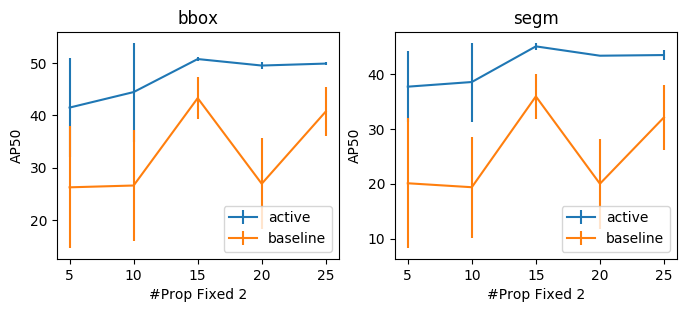

best hyperparams for /checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43/1/default/pred_label_gt5p2, 0.001 100 500 *.txt
best hyperparams for /checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43/2/default/pred_label_gt5p2, 0.001 200 500 *.txt
best hyperparams for /checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43/1/default/pred_label_gt5p4, 0.0005 100 1000 *.txt
best hyperparams for /checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43/2/default/pred_label_gt5p4, 0.001 200 1000 *.txt
best hyperparams for /checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43/1/default/pred_label_gt5p6, 0.001 200 1000 *.txt
best hyperparams for /checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43/2/default/pred_lab

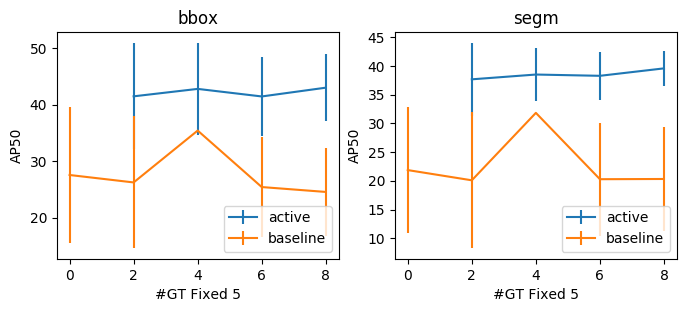

In [59]:
# job_dir_act = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/15-10-2021/15:24:56'
# job_dir_act = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/02-11-2021/08:49:36'
# job_dir_act = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/02-11-2021/19:01:55' # selection heuristic using GT

# selection heuristic using GT with area thresh > 10K
# job_dir_act = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/02-11-2021/20:39:56' 

# only chair, maxiters 1k
job_dir_act = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/07:01:43'
# job_dir_act = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/03-11-2021/01:36:30'
job_dir_def = '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/default/no_noise/03-11-2021/15:16:07'

# job_dir_act = '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/14-10-2021/19:17:17' #lr 0.0001
# job_dir_def = '/checkpoint/kavyasrinet/jobs/active_vision/pipeline/apartment_0/default/no_noise/15-10-2021/15:21:23'
# /1/default/pred_label_gt5p2'

# get_all_gtxpy(job_dir, 5, 2, 2, pref='default')
print('alpha - overall mean and var')
pfix = 2
gtfix = 10

compare(job_dir_act, job_dir_def, 3, [5,10,15,20,25], [2], act_pref='default', metric='alpha', xlabel=f'#Prop Fixed {pfix}')
# compare(job_dir_act, job_dir_def, 10, [5,10,15,20,25], [4], act_pref='default', metric='alpha', xlabel=f'#Prop Fixed {4}')

gtfix = 10
# compare(job_dir_act, job_dir_def, 10, [gtfix], [0, 2,4,6,8], act_pref='default', metric='alpha', xlabel=f'#GT Fixed {gtfix}')
gtfix = 5
compare(job_dir_act, job_dir_def, 3, [gtfix], [0, 2,4,6,8], act_pref='default', metric='alpha', xlabel=f'#GT Fixed {gtfix}')

# compare(job_dir_act, job_dir_def, 20, [5,10,15,20,25], [pfix], act_pref='activeonly', metric='alpha', xlabel=f'#Prop Fixed {pfix}')
# compare(job_dir_act, job_dir_def, 20, [gtfix], [2,4,6,8], act_pref='activeonly', metric='alpha', xlabel=f'#GT Fixed {gtfix}')


# print('beta - mean of means, var')
# compare(job_dir_act, job_dir_def, 20, [5,10,15,20,25], [pfix], act_pref='default', metric='beta', xlabel=f'#Prop Fixed {pfix}')
# compare(job_dir_act, job_dir_def, 20, [gtfix], [2,4,6,8], act_pref='default', metric='beta', xlabel=f'#GT Fixed {gtfix}')

# compare(job_dir_act, job_dir_def, 20, [5,10,15,20,25], [pfix], act_pref='activeonly', metric='beta', xlabel=f'#Prop Fixed {pfix}')
# compare(job_dir_act, job_dir_def, 20, [gtfix], [2,4,6,8], act_pref='activeonly', metric='beta', xlabel=f'#GT Fixed {gtfix}')

# print('beta - mean of means, var')
# compare(job_dir_act, job_dir_def, 20, [5,10,15,20,25], [pfix], act_pref='activeonly', metric='beta', xlabel=f'#Prop Fixed {pfix}')
# compare(job_dir_act, job_dir_def, 20, [gtfix], [2,4,6,8], act_pref='activeonly', metric='beta', xlabel=f'#GT Fixed {gtfix}')




In [23]:
def compare(log_act, log_def, key_fn, fixed_label, x_label, gts, ps, n, pref):
    # Look through n trajectories
    def get_averages(log, gts, ps, key_fn, fixed_label, pref=None):
        bm = defaultdict(lambda: defaultdict(list))
        sm = defaultdict(lambda: defaultdict(list))
        for traj in range(n):
            traj_root = os.path.join(log, str(traj))
            if pref:
                traj_root = os.path.join(traj_root, pref)
#             print(f'traj {traj_root}')
            if os.path.isdir(traj_root):
                for gt in gts:
                    for p in ps:
                        outdir = os.path.join(traj_root, f'pred_label_gt{gt}p{p}')
                        if os.path.isfile(os.path.join(outdir, 'all_results.txt')):
                            # read all_results.txt and calculate, bm, sm, and bm1...bm6, sm1...sm6
                            _bm, _sm = read_all_results(os.path.join(outdir, 'all_results.txt'), key_fn)
                            
                            # read averages file 
#                             _bm, _sm = read_metrics(os.path.join(outdir, '10_results_averaged.txt'), key_fn)
                            for k, v in _bm.items():
                                bm[k][gt if fixed_label == 'fixed propagation length' else p].append(v)
                                sm[k][gt if fixed_label == 'fixed propagation length' else p].append(v)
        
        bm_avg = defaultdict(lambda: defaultdict(int))
        sm_avg = defaultdict(lambda: defaultdict(int))
        for k, v in bm.items():
            for l, ap in v.items():
                bm_avg[k][l] = np.mean(ap)
#                 print(k, l, ap)
#             bm_avg[k] = np.mean(v)
        for k, v in sm.items():
            for l, ap in v.items():
                sm_avg[k][l] = np.mean(ap)
                
        for k, v in bm_avg.items():
            bm_avg[k] = dict(sorted(v.items()))
            
        for k, v in sm_avg.items():
            sm_avg[k] = dict(sorted(v.items()))
            
        return dict(sorted(bm_avg.items())), dict(sorted(sm_avg.items()))
    
    
    try:
        bm_act, sm_act = get_averages(log_act, gts, ps, key_fn, fixed_label, pref)
        bm_def, sm_def = get_averages(log_def, gts, ps, key_fn, fixed_label)
        
#         print(type(bm_act), bm_act)
        # Now plot, each key in met
        fig, ax = plt.subplots(2, 7, figsize=(20,10)) # col 1 for bbox, col2 for segm

        for i in range(2):
            for k in range(7):
                ax[i,k].set_xlabel(x_label)
                ax[i,k].set_xlabel('AP')
                if i == 0: # draw bbox
                    ax[i,k].set_title('bbox '+ met[k])
                    ax[i,k].errorbar(bm_act[met[k]].keys(), bm_act[met[k]].values(), label='active')
                    ax[i,k].errorbar(bm_def[met[k]].keys(), bm_def[met[k]].values(), label='baseline')
                elif i == 1: # draw segm
                    ax[i,k].set_title('segm '+ met[k])
                    ax[i,k].errorbar(sm_act[met[k]].keys(), sm_act[met[k]].values(), label='active')
                    ax[i,k].errorbar(sm_def[met[k]].keys(), sm_def[met[k]].values(), label='baseline')
                ax[i,k].legend(loc="upper left")
                
    except:
#         print(bm_act)
        raise
    
    fig.suptitle(fixed_label)
    plt.show()

activeonly, p 2


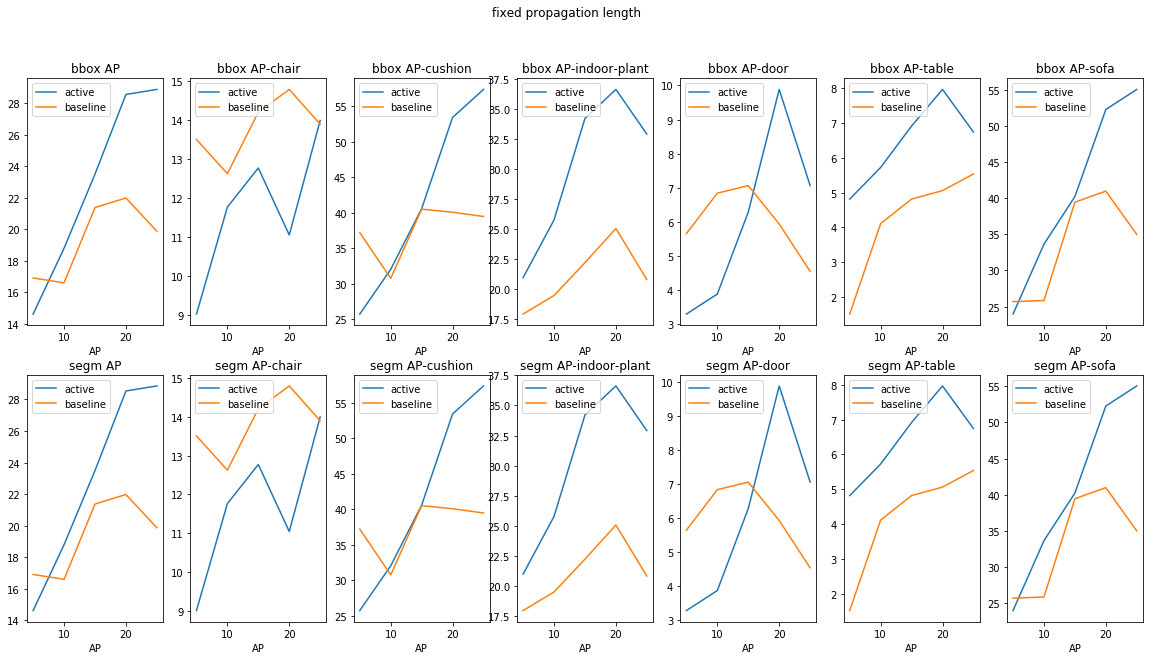

activeonly, p 4


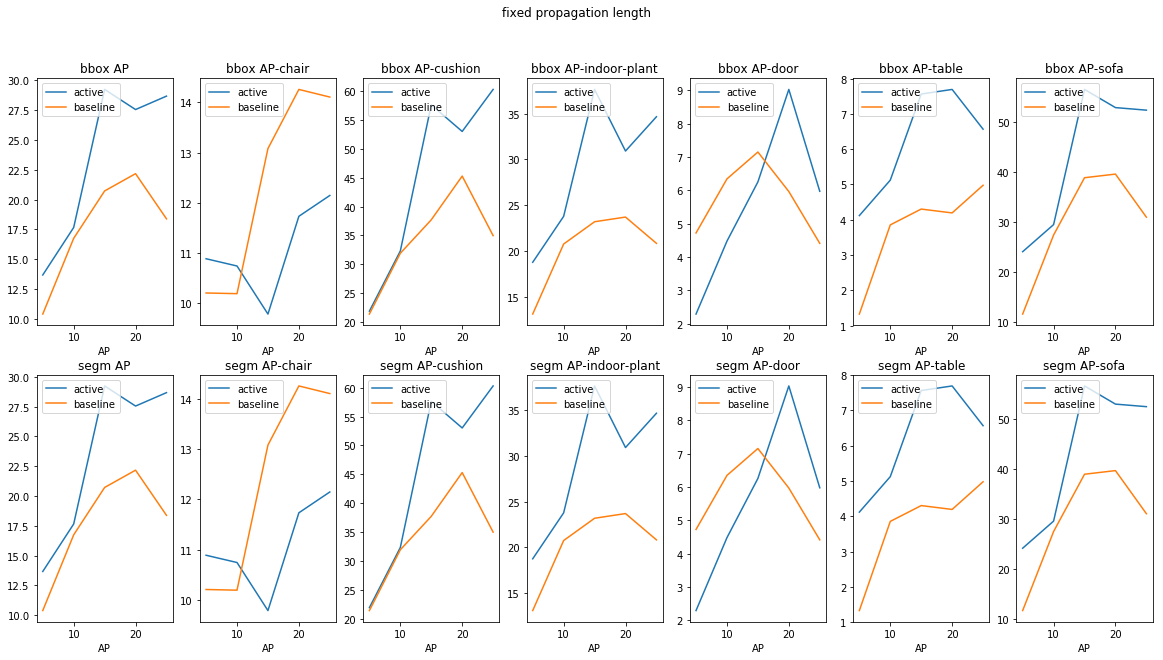

activeonly, p 6


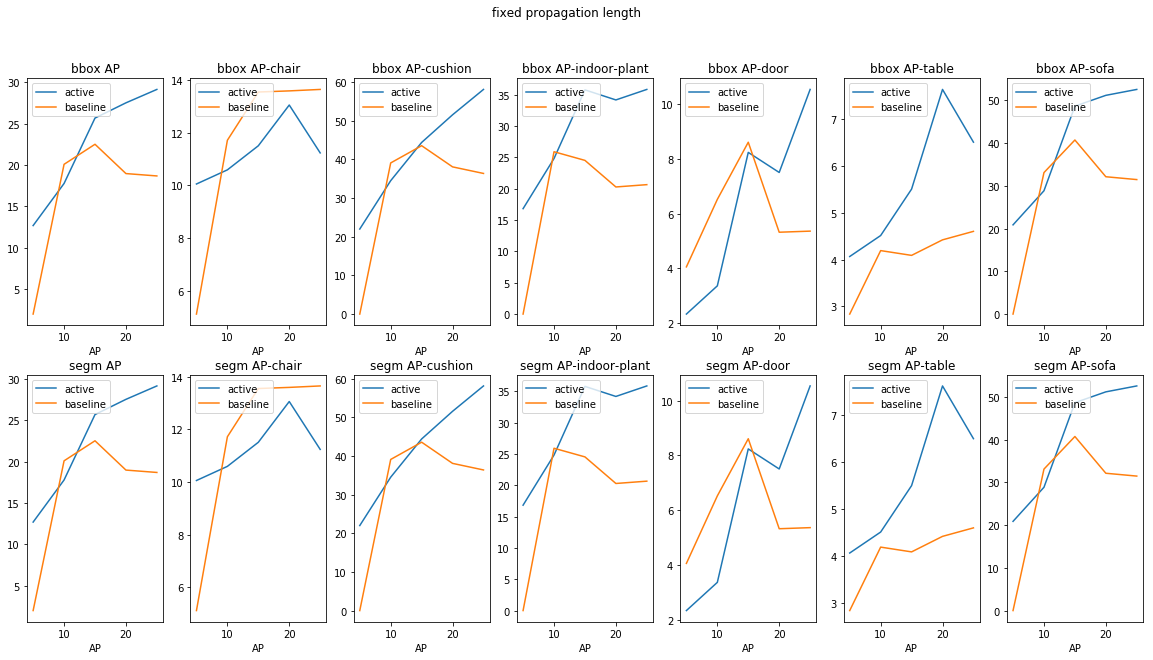

activeonly, p 8


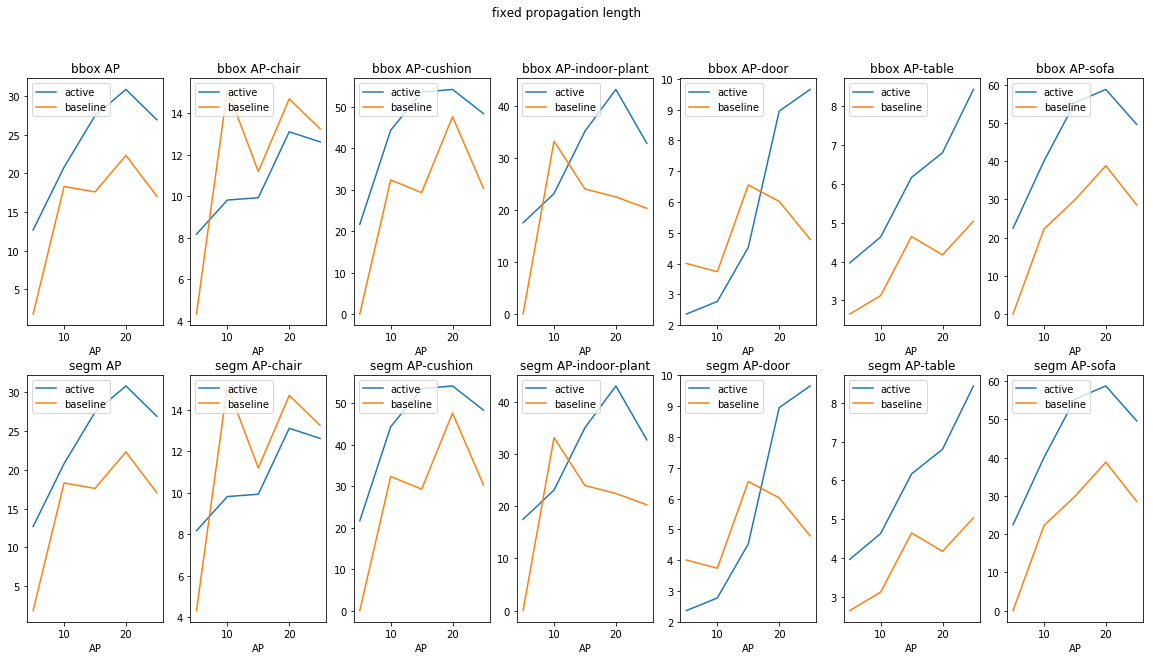

default, p 2


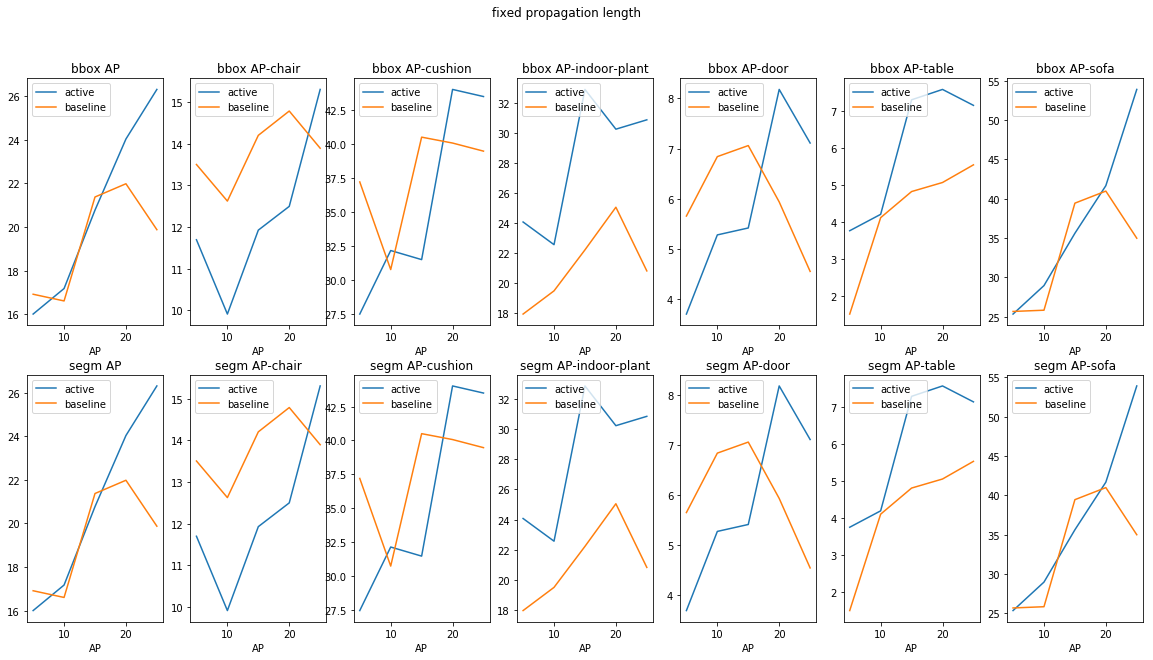

default, p 4


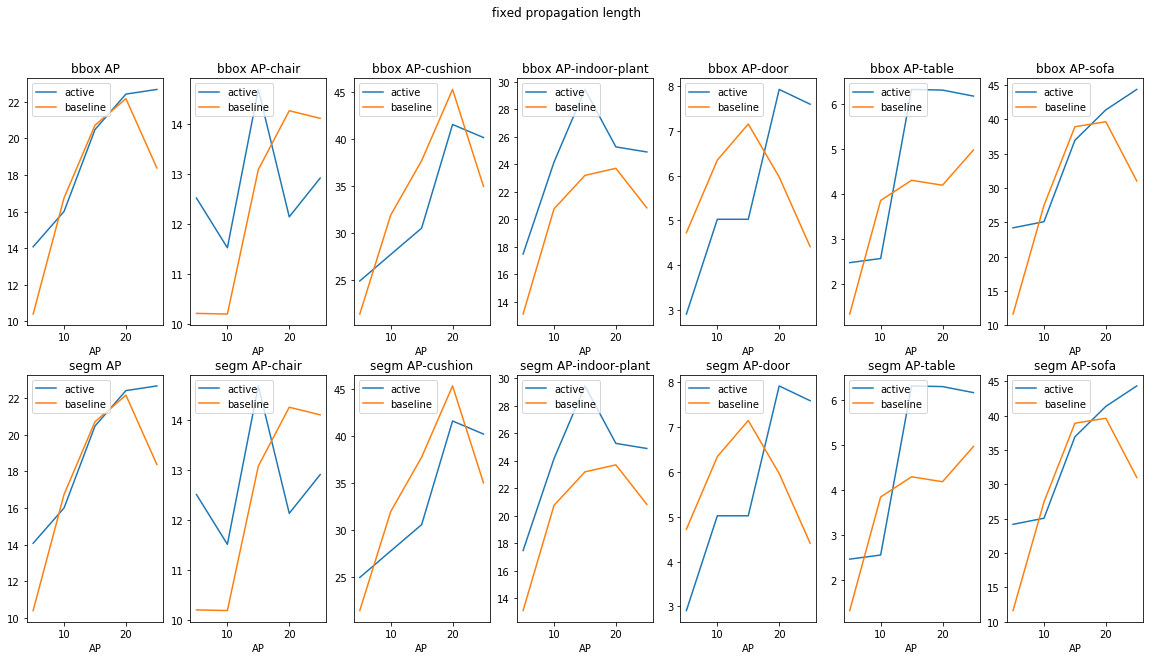

default, p 6


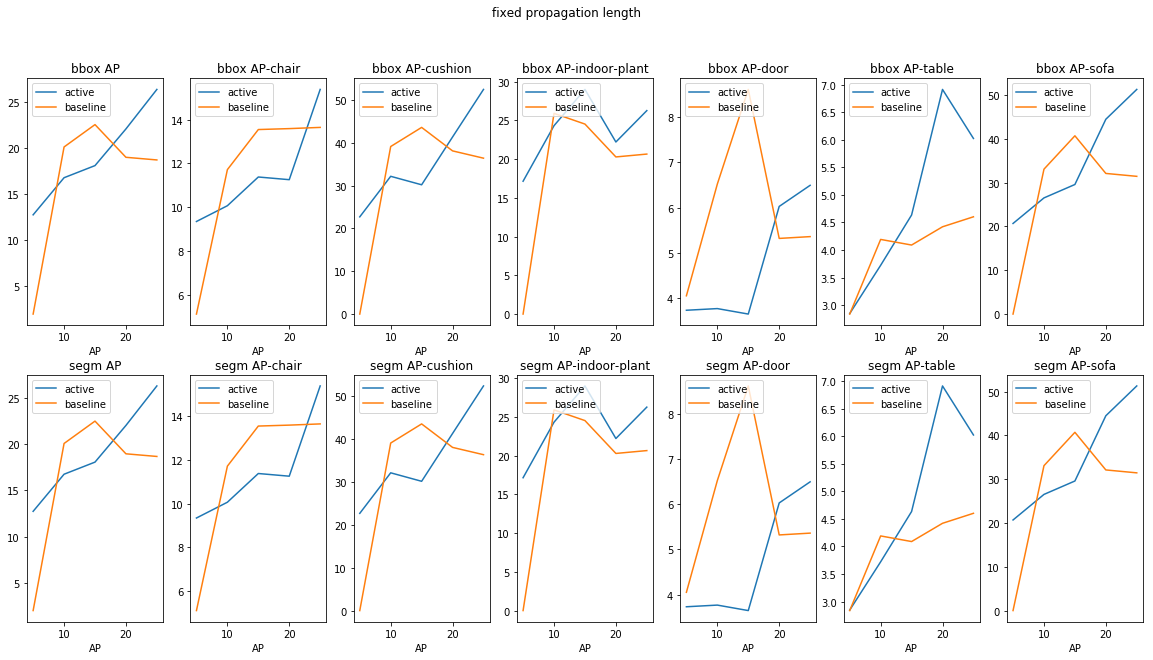

default, p 8


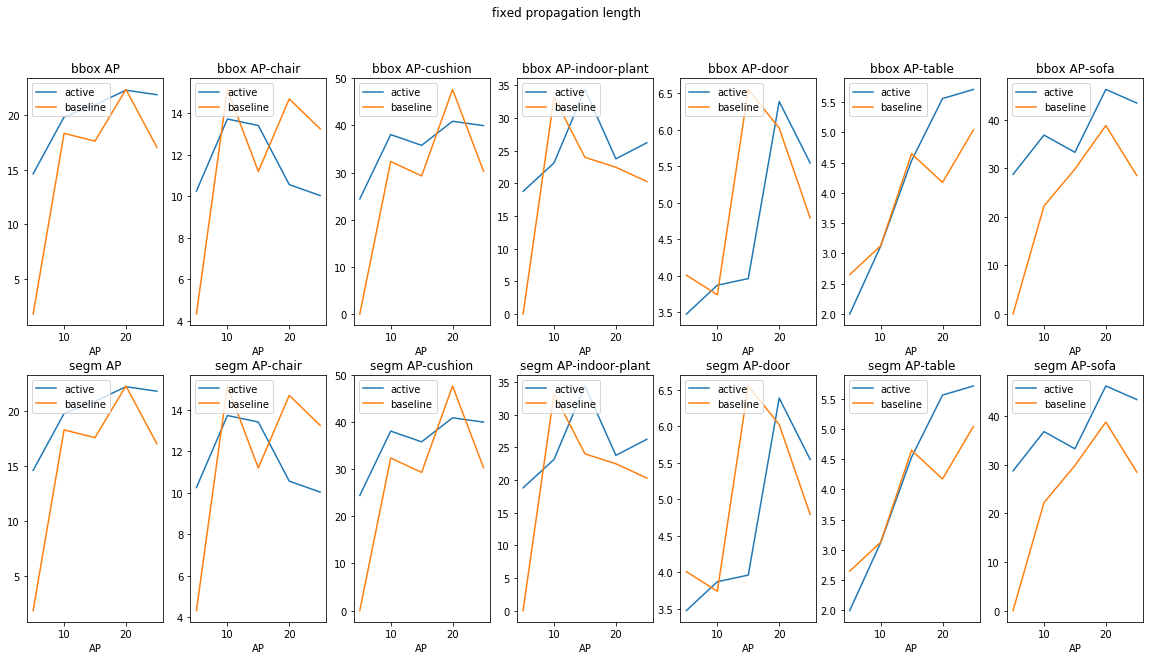

activeonly, gt 5


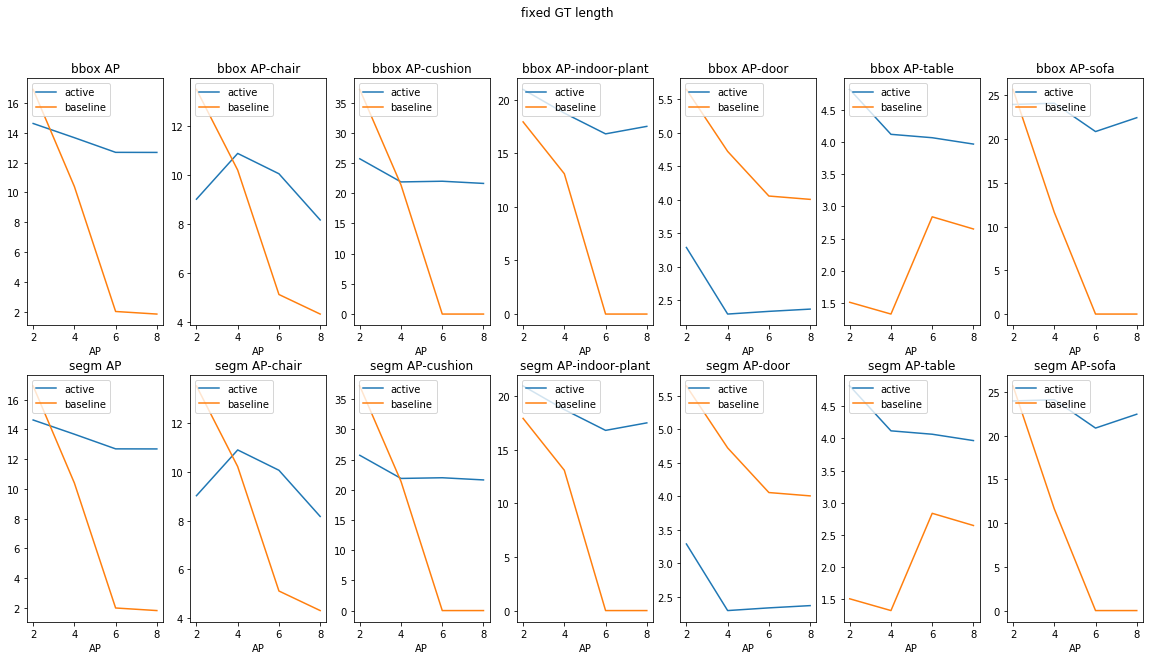

activeonly, gt 10


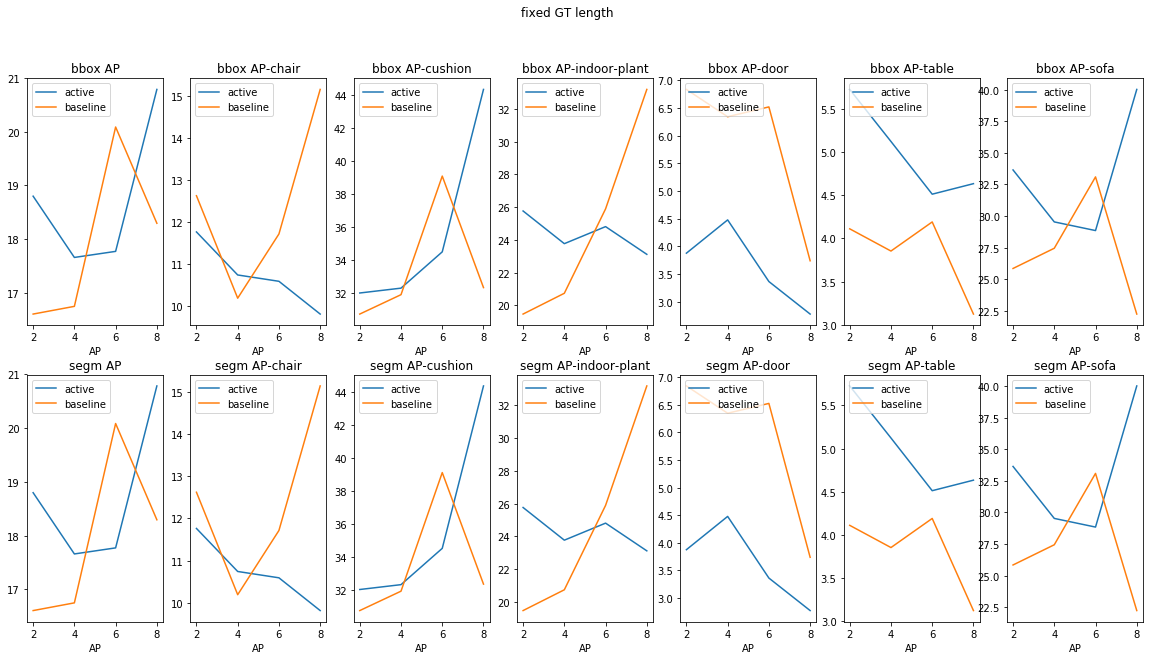

activeonly, gt 15


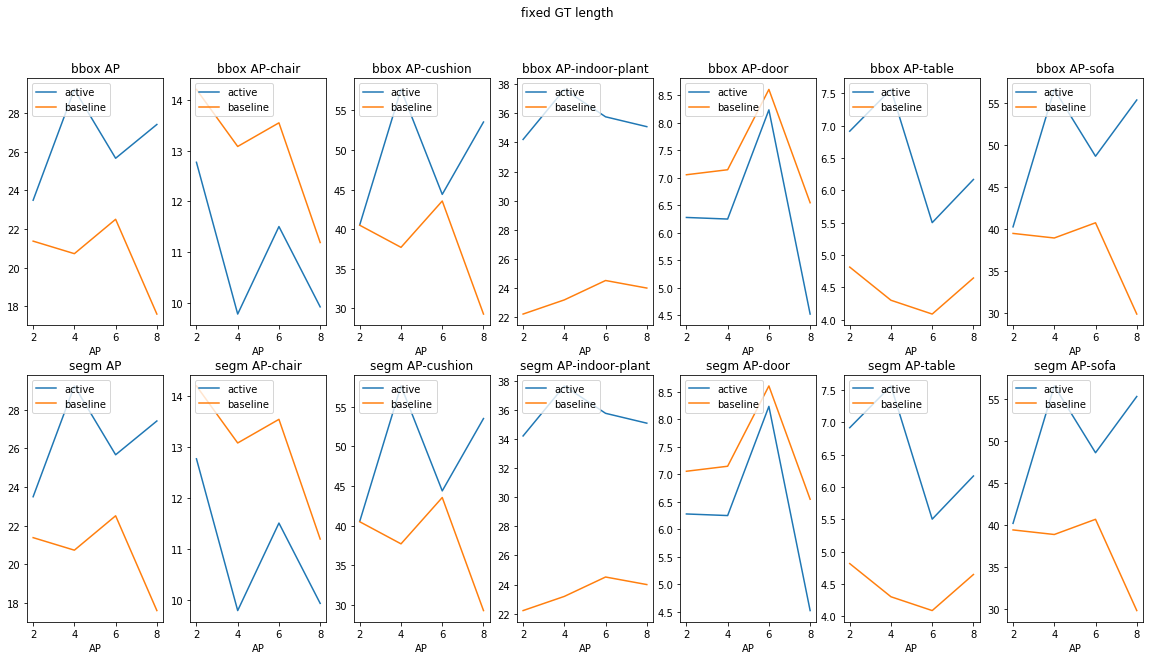

activeonly, gt 20


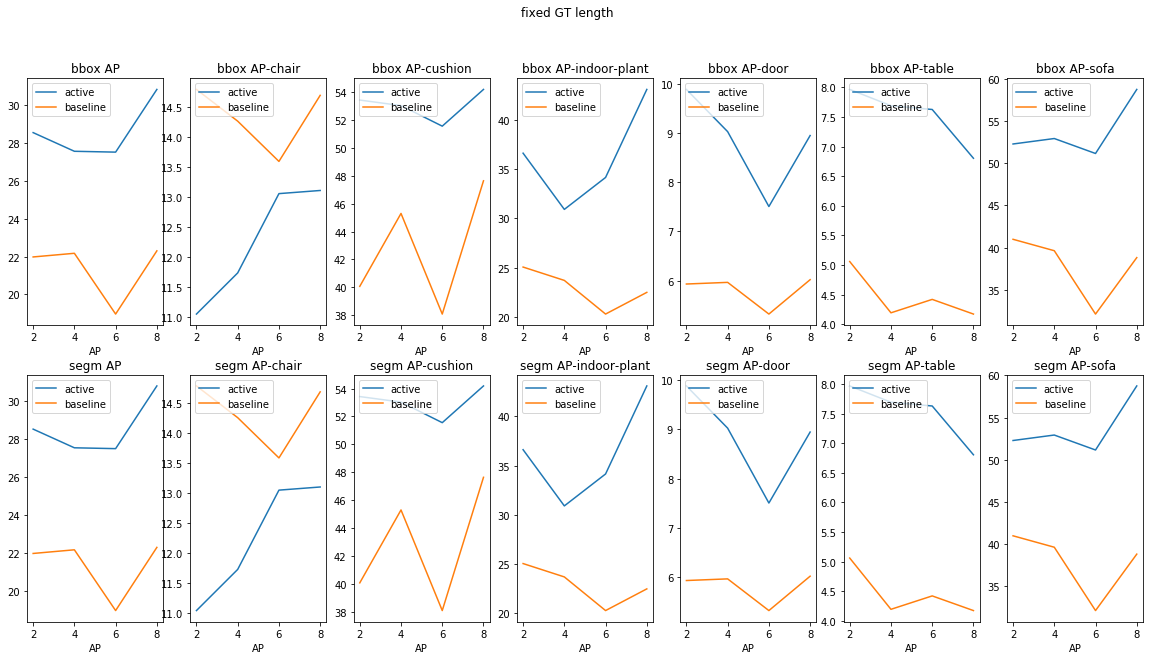

activeonly, gt 25


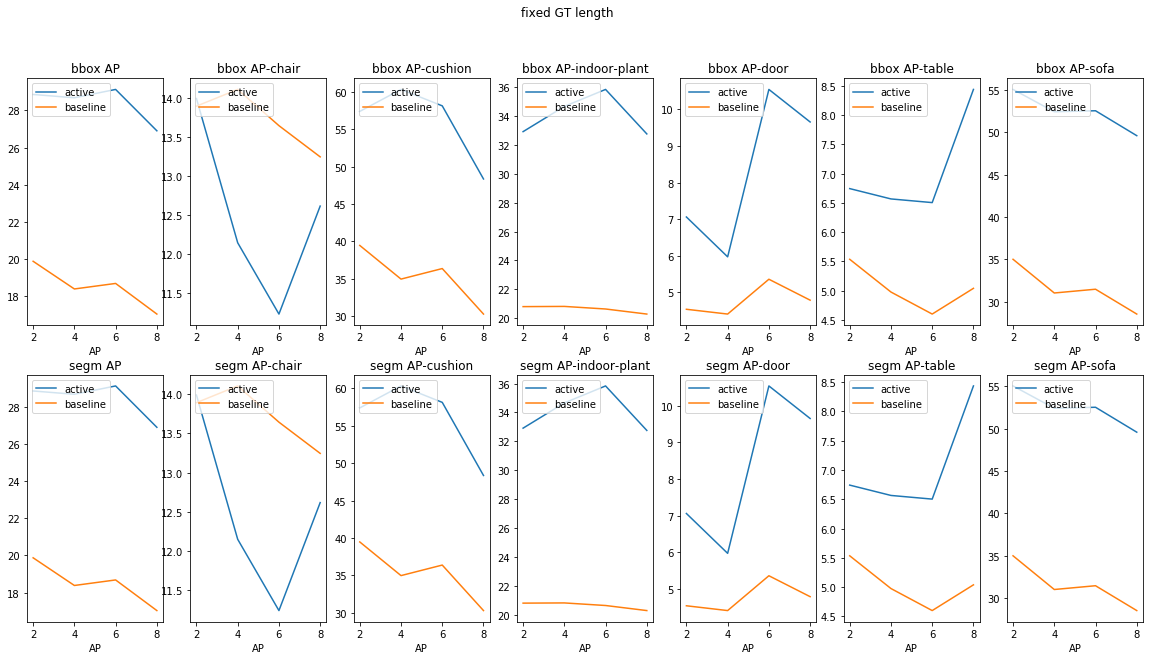

default, gt 5


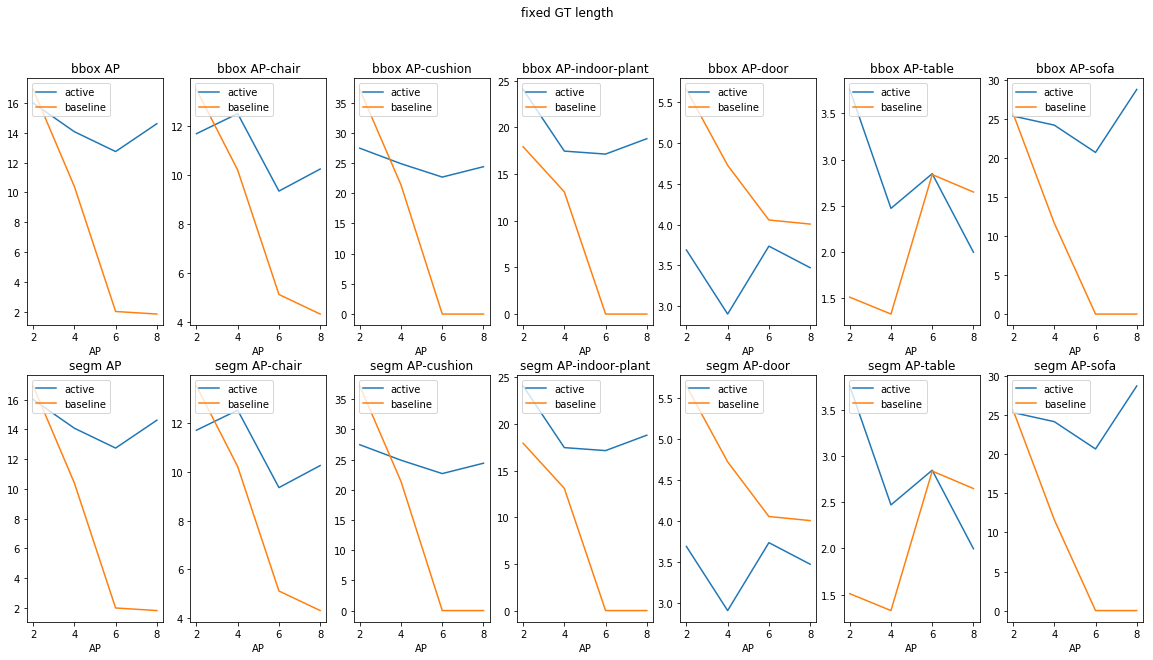

default, gt 10


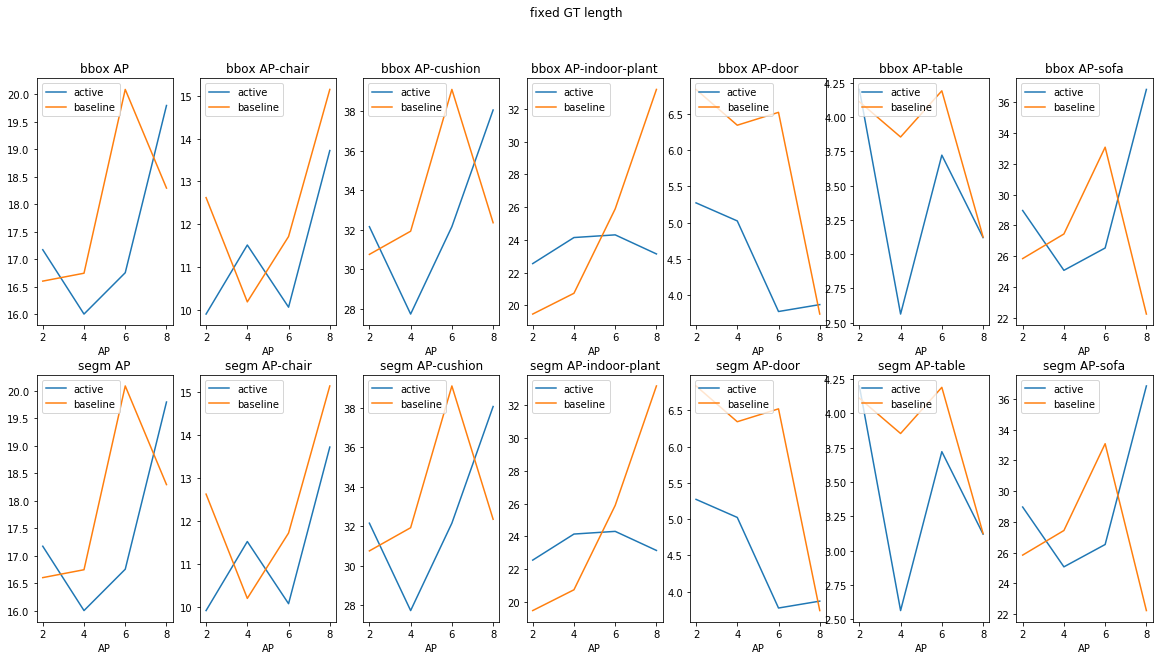

default, gt 15


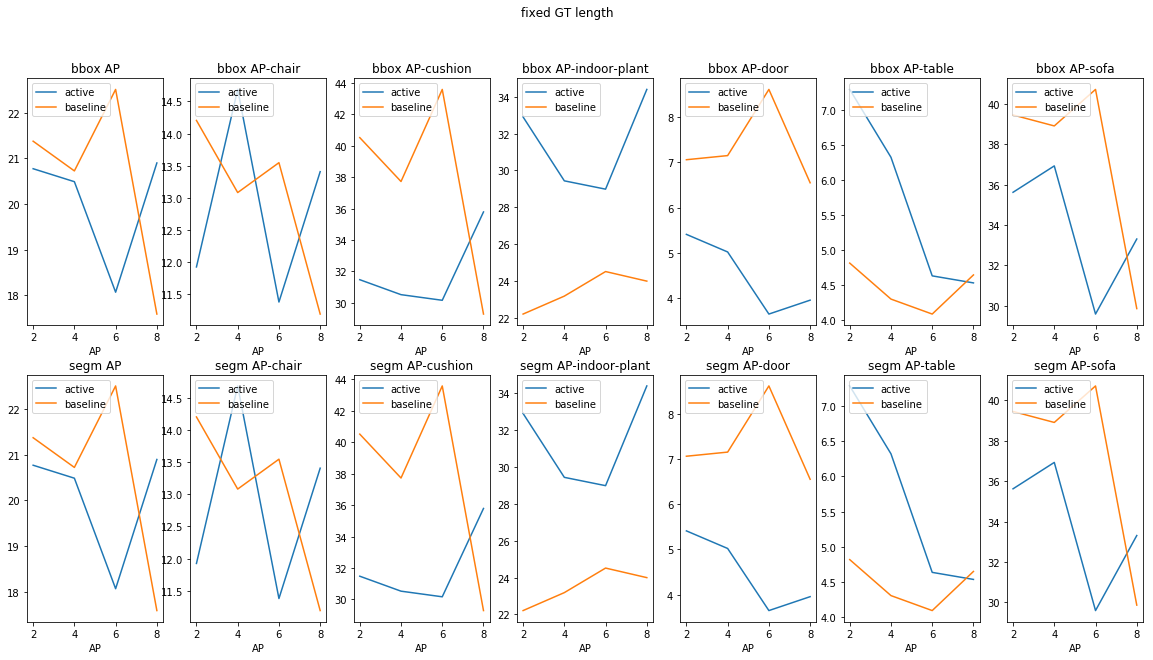

default, gt 20


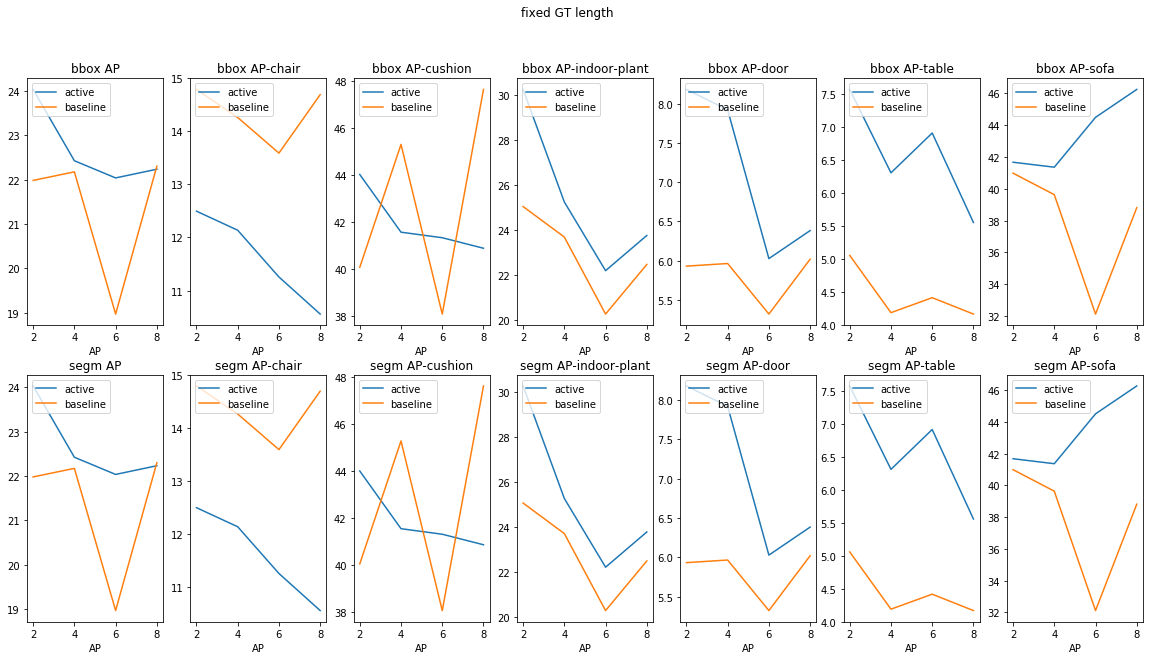

default, gt 25


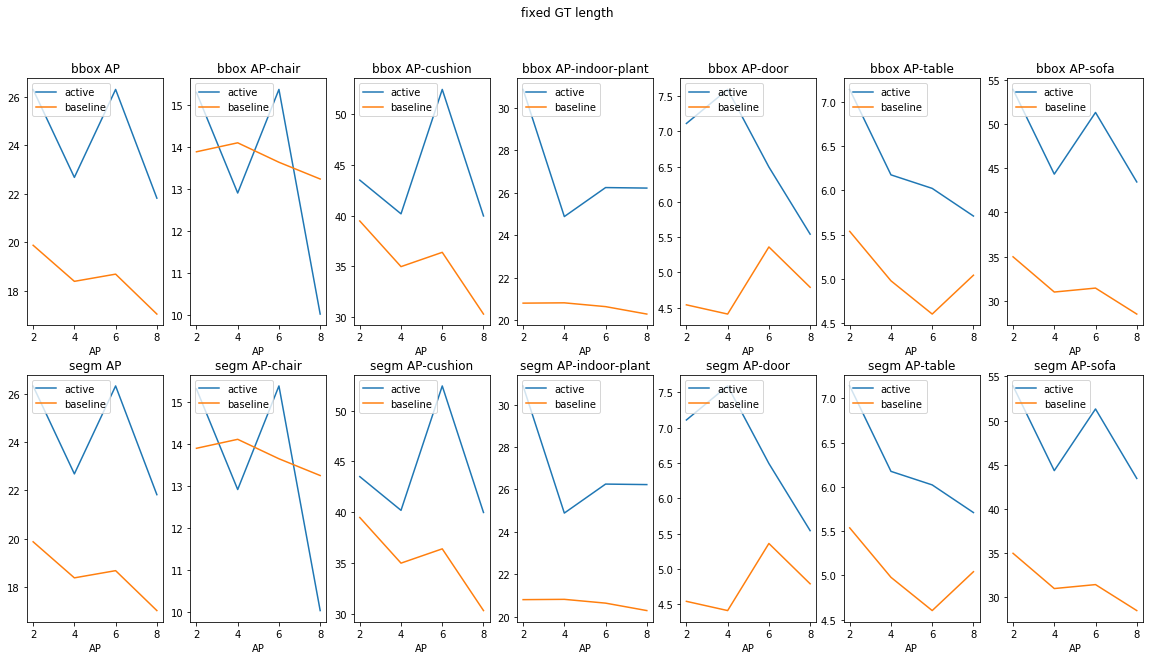

In [19]:
for pref in ['activeonly', 'default']:
    for p in [2, 4, 6, 8]:
        print(f'{pref}, p {p}')
        compare(
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-09-2021/22:45:52',
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-09-2021/12:20:58',
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-09-2021/16:59:42', 
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-10-2021/00:13:12',
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/14-10-2021/19:17:17',
            '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/15-10-2021/14:31:00',
            '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/09-09-2021/02:35:54',
            getkey_pfix,
            'fixed propagation length',
            '#GT Frames',
            gts=[5,10,15,20,25],
            ps=[p],
            n=10,
            pref=pref
        )
    
for pref in ['activeonly', 'default']:
    for gt in [5,10,15,20,25]:
        print(f'{pref}, gt {gt}')
        compare(
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-09-2021/22:45:52',
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-09-2021/12:20:58',
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-09-2021/16:59:42', 
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-10-2021/00:13:12',
        #     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/14-10-2021/19:17:17',
            '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/15-10-2021/14:31:00',
            '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/09-09-2021/02:35:54',
            getkey_gtfix,
            'fixed GT length',
            'Propagation length',
            gts=[gt],
            ps=[2,4,6,8],
            n=10,
            pref=pref
        )

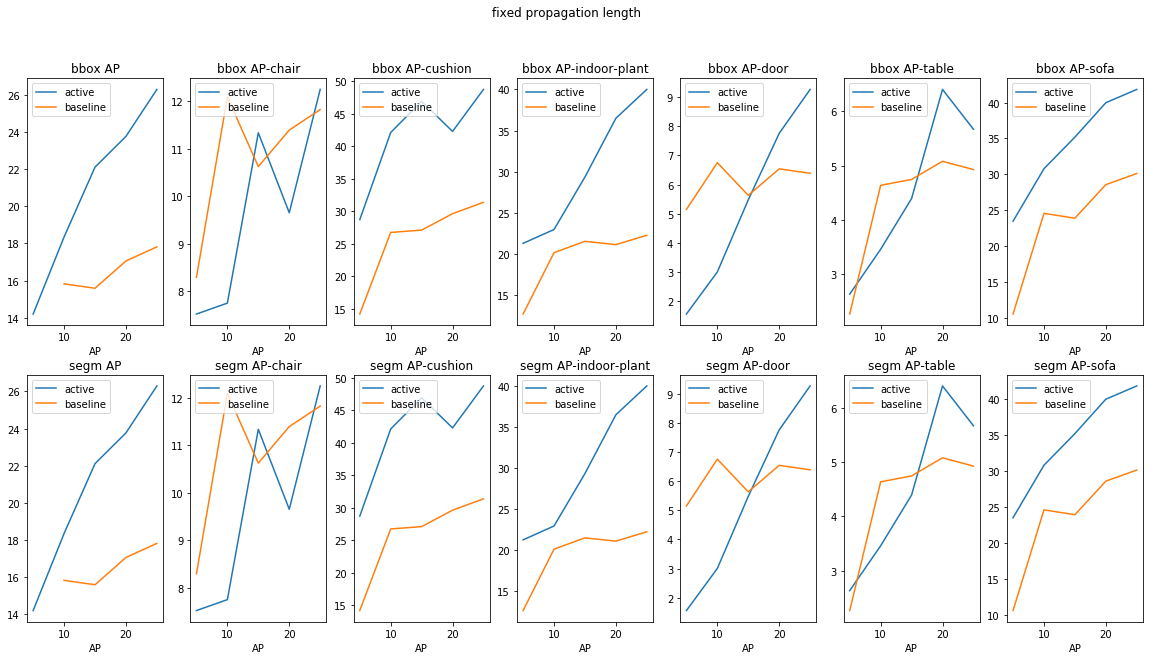

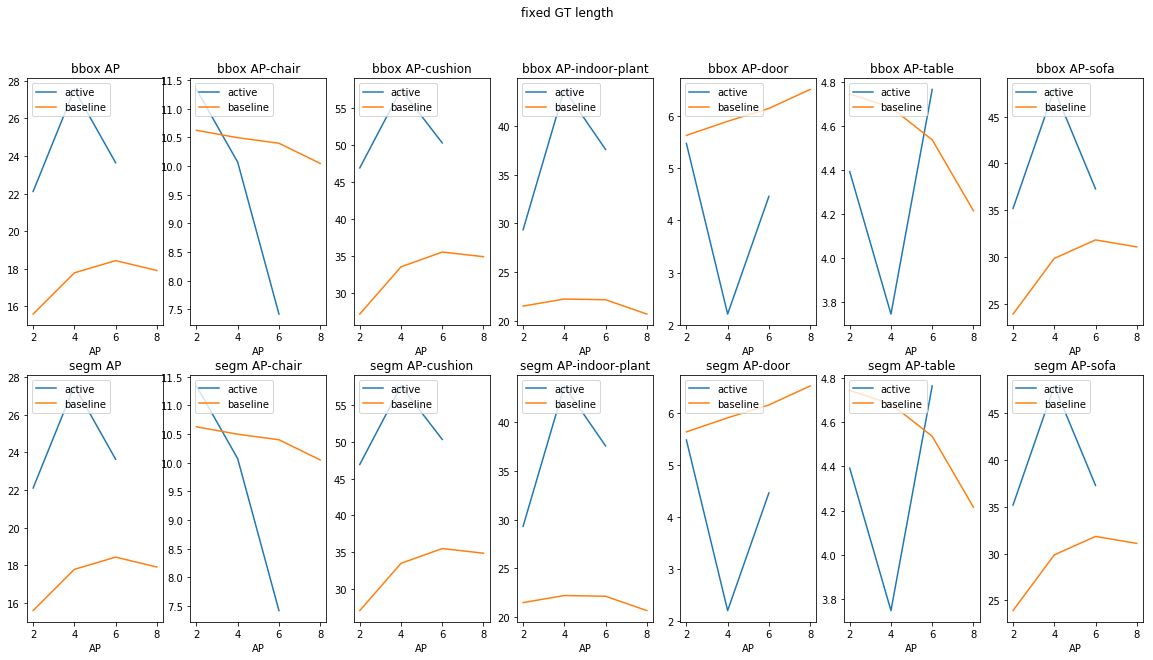

In [8]:
compare(
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-09-2021/22:45:52',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-09-2021/12:20:58',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-09-2021/16:59:42', 
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/noise/13-10-2021/21:46:24',
    '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/default/noise/09-09-2021/10:21:50', 
    getkey_pfix,
    'fixed propagation length',
    '#GT Frames',
    gts=[5,10,15,20,25],
    ps=[2],
    n=40,
    pref='activeonly'
)

compare(
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-09-2021/22:45:52',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-09-2021/12:20:58',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-09-2021/16:59:42', 
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/noise/13-10-2021/21:46:24',
    '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/default/noise/09-09-2021/10:21:50', 
    getkey_gtfix,
    'fixed GT length',
    'Propagation length',
    gts=[15],
    ps=[2,4,6,8],
    n=40,
    pref='activeonly'
)

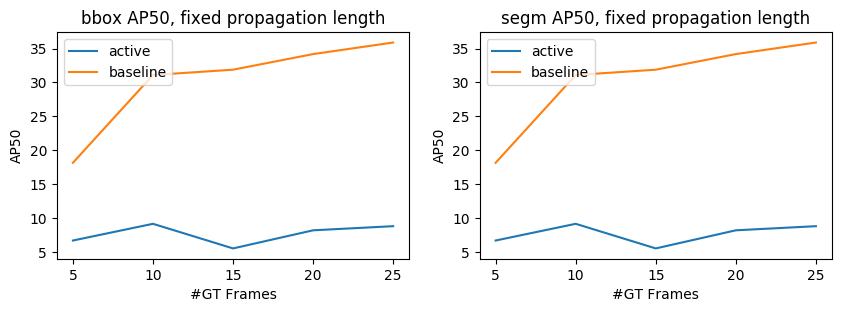

json.loads exception, skipping ('/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-10-2021/13:41:32/1/default/pred_label_gt5p2/all_results.txt', {'bbox': {'AP': 18.177412915630413, 'AP50': 36.28354873741289, 'AP75': 14.534407170935419, 'APs': 7.336800022121846, 'APm': 17.925181078597724, 'APl': 16.18498532164609, 'AP-chair': 13.549336241147097, 'AP-cushion': 29.734288418509585, 'AP-door': 2.656553891422681, 'AP-indoor-plant': 15.025014213697935, 'AP-sofa': 47.7434268868818, 'AP-table': 0.3558578421233754}, 'segm': {'AP': 18.671780583025615, 'AP50': 33.881126444417056, 'AP75': 19.831531888005095, 'APs': 9.072163406957765, 'APm': 19.647636014434323, 'APl': 15.55784177226936, 'AP-chair': 9.746690017222168, 'AP-cushion': 44.586710486807256, 'AP-door': 1.774557752103516, 'AP-indoor-plant': 11.556410209031236, 'AP-sofa': 44.36631503298951, 'AP-table': 0.0}})
json.loads exception, skipping ('/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straigh

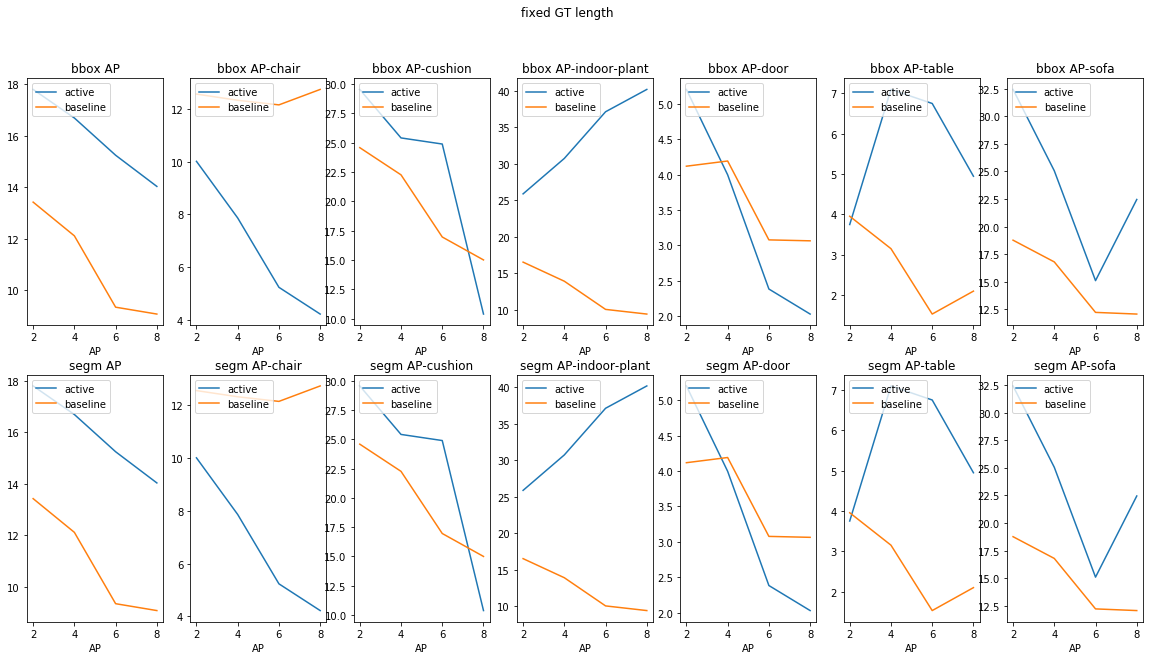

In [15]:
compare(
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-09-2021/22:45:52',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/13-09-2021/12:20:58',
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-09-2021/16:59:42', 
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/12-10-2021/13:41:32/',
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/09-09-2021/02:35:54',
    getkey_pfix,
    'fixed GT length',
    'Propagation length',
    gts=[5],
    ps=[2,4,6,8],
    n=100,
    pref='default',
)

# compare(
#     '/checkpoint/kavyasrinet/jobs/active_vision/pipeline/apartment_0/straightline/no_noise/09-09-2021/09:15:45', 
#     '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/default/no_noise/09-09-2021/02:35:54',
#     getkey_gtfix,
#     'fixed GT length',
#     'Propagation length',
#     gts=[5],
#     ps=[2,4,6,8],
#     n=100
# )

json.loads exception, skipping ('/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/noise/13-10-2021/21:46:24/5/default/pred_label_gt5p2/all_results.txt', {'bbox': {'AP': 3.4159282048220656, 'AP50': 7.3289450707201205, 'AP75': 3.338075376396777, 'APs': 1.3156799883219894, 'APm': 3.681764426555261, 'APl': 4.493783410897442, 'AP-chair': 8.576108750903492, 'AP-cushion': 0.0, 'AP-door': 11.270265479693407, 'AP-indoor-plant': 0.0, 'AP-sofa': 0.0, 'AP-table': 0.6491949983354915}, 'segm': {'AP': 2.18526983393429, 'AP50': 3.7917727555830867, 'AP75': 2.043001421629148, 'APs': 0.0005112624083123547, 'APm': 1.45286183761382, 'APl': 4.423673747299158, 'AP-chair': 2.2276833409185604, 'AP-cushion': 0.0, 'AP-door': 10.88393566268718, 'AP-indoor-plant': 0.0, 'AP-sofa': 0.0, 'AP-table': 0.0}})
json.loads exception, skipping ('/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/noise/13-10-2021/21:46:24/5/default/pred_label_gt5p4/all_results.txt', {'bbox': {'AP

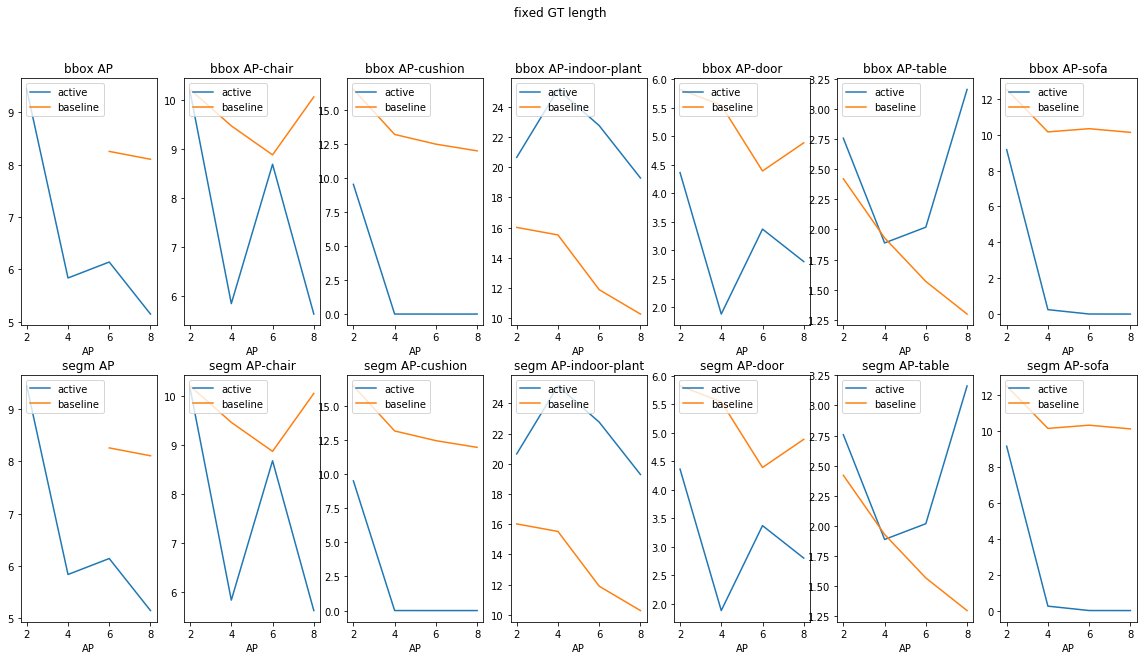

In [5]:
compare(
    '/checkpoint/apratik/jobs/active_vision/pipeline/apartment_0/straightline/noise/13-10-2021/21:46:24',
    '/checkpoint/soumith/jobs/active_vision/pipeline/apartment_0/default/noise/09-09-2021/10:21:50', 
    getkey_gtfix,
    'fixed GT length',
    'Propagation length',
    gts=[5],
    ps=[2,4,6,8],
    n=100,
    pref='default',
)